In [36]:
import numpy as np 
data_trainX = np.loadtxt('train_triplets.txt')
data_testX = np.loadtxt('test_triplets.txt')

In [37]:
photos = np.zeros((10000,10))
for pic in range(10000):
    for i in range(10):
        photos[pic,i] = 5 - np.random.rand()*10

In [38]:
for i in range(len(data_trainX)-10000):
    first = int(data_trainX[i,0])
    second = int(data_trainX[i,1])
    one = photos[first,:]
    two = photos[second,:]
    diff = one - two
    kick = []
    for i in range(len(diff)):
        kick= diff*np.random.rand()
    photos[second,:] = photos[second,:] + kick

In [39]:
predictions = []
for i in range(10000):
    first = int(data_trainX[i+len(data_trainX)-10000,0])
    second = int(data_trainX[i+len(data_trainX)-10000,1])
    third = int(data_trainX[i+len(data_trainX)-10000,2])
    one = photos[first,:]
    two = photos[second,:]
    three = photos[third,:]
    dist_1 = np.linalg.norm(one-two)
    dist_2 = np.linalg.norm(one-three)
    if dist_1 > dist_2:
        predictions.append(0)
    if dist_1 < dist_2:
        predictions.append(1)
    if dist_1 == dist_2:
        print("WARNING!")

In [40]:
print(np.sum(predictions)/len(predictions))

0.6516


In [7]:
np.savetxt("predictions.txt",predictions,fmt="%i")

[106 106 107 ...  85  83  81]


ValueError: Expected 2D array, got 1D array instead:
array=[106. 106. 107. ...  85.  83.  81.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

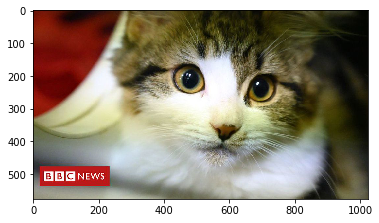

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.decomposition import PCA

cat = mpimg.imread('cat.jpg')
imgplot = plt.imshow(cat)
r = np.ravel(cat[:,:,0])
g = np.ravel(cat[:,:,1])
b = np.ravel(cat[:,:,2])
pca = PCA(n_components=2)
r = pca.fit_transform(r)
g = pca.fit_transform(g)
b = pca.fit_transform(b)
gatto = list([r,g,b])
np.shape(gatto)

In [ ]:
library(jpeg)
The readJPEG function is used to convert the image into its matrix representation.

cat <- readJPEG('cat.jpg')
ncol(cat)
## [1] 600
nrow(cat)
## [1] 398
The cat image is now represented as three 600x398 matrices as an array with each matrix corresponding to the RGB color value scheme. Extract the individual color value matrices to perform PCA on each.

r <- cat[,,1]
g <- cat[,,2]
b <- cat[,,3]
Principal component analysis is performed on each color value matrix. As this example is focused on image compression and not description or interpretation of the variables, the data does not require centering (subtracting the variable means from the respective observation vectors), and the center argument is set to FALSE. If the argument is not set to FALSE, the returned image will not have the right RGB values due to having their respective means subtracted from each pixel color vector.

cat.r.pca <- prcomp(r, center = FALSE)
cat.g.pca <- prcomp(g, center = FALSE)
cat.b.pca <- prcomp(b, center = FALSE)
Collect the PCA objects into a list.

rgb.pca <- list(cat.r.pca, cat.g.pca, cat.b.pca)
We are now ready to compress the image! Now that the principal components are found for each color value matrix, we have new dimensions that describe the original data (pixels). The pixel values are then projected onto the new dimensions of the data for each respective matrix.

The following loop reconstructs the original image using the projections of the data using increasing amounts of principal components. We will see that as the number of principal components increase, the more representative of the original image the reconstruction becomes. This sequential improvement in quality is because as more principal components are used, the more the variance (information) is described. The first few principal components will have the most drastic change in quality while the last few components will not make much if any, difference to quality.

for (i in seq.int(3, round(nrow(cat) - 10), length.out = 10)) {
  pca.img <- sapply(rgb.pca, function(j) {
    compressed.img <- j$x[,1:i] %*% t(j$rotation[,1:i])
  }, simplify = 'array')
  writeJPEG(pca.img, paste('compressed/cat_compressed_', round(i,0), '_components.jpg', sep = ''))
}

In [2]:
def rescale_image (img_data, block_col, block_row):
    n_col = len(img_data[0,:,0])
    n_row = len(img_data[:,0,0])
    div_riga = int(n_col/block_row)
    div_col = int(n_row/block_col)
    
    def colour (img_data, block_col, block_row, colore):
        columns = []
        for r in range(len(img_data[:,0,colore])):
            riga = []
            for j in range(block_row):
                riga.append(np.array(img_data[r,j*div_riga:(j+1)*div_riga,colore]).mean())
            columns.append(riga)

        columns = np.array(columns)

        rows = []
        for c in range(len(columns[0,:])):
            col = []
            for j in range(block_col):
                col.append(np.array(columns[j*div_col:(j+1)*div_col,c]).mean())
            rows.append(col)
        
        rows = np.array(rows)
        rows = rows.T

        return rows

    rimage = []
    red = colour(img_data, block_col, block_row, 0)
    green = colour(img_data, block_col, block_row, 1)
    blue = colour(img_data, block_col, block_row, 2)
    
    return np.dstack((red,green,blue))


def euclidian_distance (img_1, img_2, img_3):
    image_1 = img_1.ravel()
    image_2 = img_2.ravel()
    image_3 = img_3.ravel()
    
    dist1 = np.linalg.norm(image_1-image_2)
    dist2 = np.linalg.norm(image_1-image_3)
    
    if dist1 < dist2 : return 1
    else: return 2   
    
def jump_features(img, n):
    length = len(img)
    v = []
    for i in range(len(img)):
        if i%2 == 0: v.append(img[i])
    return v

In [3]:
height = 242
width = 354

images = []
for i in tqdm(range(5000)):
    name = '0'*(5-len(str(i))) + str(i)
    img = np.array(image.imread('food/'+name+'.jpg'))
    img = img[:height,:width,:]
    # Transpose?
    img = img.ravel()
    #img = jump_features(img, 2)
    images.append(img)


100%|██████████| 5000/5000 [00:35<00:00, 142.42it/s]


In [6]:
M = []
print(len(images[0]))
'''for i in tqdm(range(len(images))):
    v = []
    for j in range(len(images[i])):
        print(j)
        if j%2 == 0: v.append(images[i][j])
    M.append(v)'''

257004


'for i in tqdm(range(len(images))):\n    v = []\n    for j in range(len(images[i])):\n        print(j)\n        if j%2 == 0: v.append(images[i][j])\n    M.append(v)'

In [ ]:
images = np.array(images)
print(images.shape)
# 20X30 (Pca=50)--> 1.5s (Pca=10)--> 0.61s
# 40X60 (Pca=50)--> 3.9s (Pca=10)--> 2.53s
# 80X120 (Pca=50)--> 13.5s (Pca=10)--> 10.6s
# 120X180 (Pca=50)--> 43s/31s (Pca=10)--> 69s
# 180X220 (Pca=50)--> 360s/31s (Pca=10)--> 69s

In [ ]:
pca = PCA(n_components=50)
images_pca = pca.fit_transform(images) 

In [ ]:
trainY = []
for i in range(len(data_trainX)):
    rand = random.randint(2)
    trainY.append(rand)
    if rand==1:
        temp = data_trainX[i,1]
        data_trainX[i,1] = data_trainX[i,2]
        data_trainX[i,2] = temp
    
trainX = []
for i in range(len(data_trainX)):
    img_1 = images_pca[int(data_trainX[i,0])]
    img_2 = images_pca[int(data_trainX[i,1])]
    img_3 = images_pca[int(data_trainX[i,2])]
    img_tot = np.c_[img_1,img_2,img_3]
    img_tot = img_tot.T
    img_tot = img_tot.ravel()
    trainX.append(img_tot)
    
classifier = MLPClassifier()
classifier.fit(trainX[:50000,:], trainY[:50000])
predictions = classifier.predict(trainX[50000:,:])
print(pd.DataFrame(np.c_[predictions, trainY[50000:]]))

In [ ]:
pp1 = ProgressPlot()

ones = 0
twos = 0
for i in range(len(data_trainX)):
    img_1 = images_pca[int(data_trainX[i,0])]
    img_2 = images_pca[int(data_trainX[i,1])]
    img_3 = images_pca[int(data_trainX[i,2])]
    
    if euclidian_distance(img_1, img_2, img_3) == 1: ones += 1
    else: twos += 1
        
    pp1.update(ones/(twos+ones))
    
pp1.finalize()

<IPython.core.display.Javascript object>

In [24]:
from tqdm import tqdm

v = []
massimi = []
for i in tqdm(range(len(filelist))):
    current = filelist[i]
    w = np.zeros(len(current))
    max_i = []
    for j in range(3):
        index = current.index(max(current))
        w[index] = max(current)
        max_i.append(index)
        current[index] = 0
    massimi.append(max_i)
    v.append(w)
n_cat = len(set(massimi.ravel()))
print(n_cat)

images = np.zeros((len(filelist),n_cat))

for i in range(len(filelist)):
    for j in range(len(massimi[i]):
        ind = massimi[i][j]
        images[i,ind] = v[i,ind]

    
    


NameError: name 'filelist' is not defined

In [22]:
import numpy as np
a = [1,7,3]
#print(np.max(a))
#print(np.where(a,2))
a.index(min(a))

0

In [247]:
height = 16
width = 20
ones = 0
twos = 0

pp = ProgressPlot()

for i in range(len(data_trainX)):
    
    name_1 = '0'*(5-len(str(int(data_trainX[i,0])))) + str(int(data_trainX[i,0])) 
    name_2 = '0'*(5-len(str(int(data_trainX[i,1])))) + str(int(data_trainX[i,1])) 
    name_3 = '0'*(5-len(str(int(data_trainX[i,2])))) + str(int(data_trainX[i,2])) 
    
    img_1 = np.array(image.imread('food/'+name_1+'.jpg'))
    img_2 = np.array(image.imread('food/'+name_2+'.jpg'))
    img_3 = np.array(image.imread('food/'+name_3+'.jpg'))
    
    img_1 = rescale_image(img_1, height, width)
    img_2 = rescale_image(img_2, height, width)
    img_3 = rescale_image(img_3, height, width)
    
    if euclidian_distance(img_1, img_2, img_3) == 1: ones += 1
    else: twos += 1
        
    pp.update(ones/(twos+ones))
    
pp.finalize()

'''alpha = Image.fromarray(new_image.astype(np.uint8),mode='RGB')
alpha.save('my.png')
alpha.show()'''

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

time: 1h 27min 11s


In [27]:
shape = []
for i in tqdm(range(10000)):
    name = '0'*(5-len(str(i))) + str(i)
    img = np.array(image.imread('food/'+name+'.jpg'))
    shape.append(img.shape)
shape = np.array(shape)
print(max(shape[:,0]), max(shape[:,1]))
print(min(shape[:,0]), min(shape[:,1]))

100%|██████████| 10000/10000 [01:09<00:00, 143.06it/s]

342 512
242 354
time: 1min 9s


In [25]:
print(len(data_trainX))

59515
time: 699 µs


In [6]:
import numpy as np

img_1 = [1,2]
img_2 = [3,4]
img_3 = [5,6]
img_tot = np.c_[img_1,img_2,img_3]
print(img_tot)
img_tot = img_tot.T
img_tot.ravel()

[[1 3 5]
 [2 4 6]]


array([1, 2, 3, 4, 5, 6])

In [82]:
from PIL import Image
img = Image.open("second.jpg")
# Resize smoothly down to 16x16 pixels
imgSmall = img.resize((16,16),resample=Image.BILINEAR)

## Scale back up using NEAREST to original size
#result = imgSmall.resize(img.size,Image.NEAREST)

print(type(imgSmall))

# Save
imgSmall.save('result.jpg')
img_data = image.imread('result.jpg')
print(img_data.shape)

<class 'PIL.Image.Image'>
(16, 16, 3)
time: 13.5 ms


In [56]:
clt = KMeans(n_clusters = 5)
clt.fit(img_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

time: 2.63 s


In [60]:
# import the necessary packages
import cv2
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

hist = utils.centroid_histogram(clt)
bar = utils.plot_colors(hist, clt.cluster_centers_)
# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

ModuleNotFoundError: No module named 'cv2'

time: 14.2 ms
